In [5]:
import torch
import numpy as np
from tqdm import tqdm

In [6]:
from torchvision import datasets
from torchvision.transforms import ToTensor

# define datasets
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
    )

test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
    )

# define dataloader
BATCH_SIZE = 4

train_loader = torch.utils.data.DataLoader(train_data, BATCH_SIZE, shuffle = True, drop_last = True)

test_loader = torch.utils.data.DataLoader(test_data, BATCH_SIZE)

In [53]:
# load in model
from train import CNN
model = torch.load('simclrtest.pt')
model.eval()

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (out): Linear(in_features=1568, out_features=32, bias=True)
)

In [54]:
laten_outs = []
# train cluster
for images, labels in tqdm(train_loader):
    # infer on model and convert to numpy
    laten_spaces = model(images).cpu().detach().numpy()

    # append laten_spaces to laten_outs
    laten_outs.append(laten_spaces)

100%|██████████| 15000/15000 [00:14<00:00, 1031.03it/s]


In [55]:
vectors = np.concatenate(laten_outs)

# train kmeans on vectors 

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 300, max_iter = 1000).fit(vectors)

In [67]:
# evalute clusters on test
clusters = []
known_values = []

# iterate over each batch
for images, labels in tqdm(train_loader):

    # infer on model
    laten_spaces = model(images)

    # predict cluster 
    preds = kmeans.predict(laten_spaces.cpu().detach().numpy())

    # add each predicion to clusters
    clusters.append(preds)

    # add each label to known values 
    known_values.append(labels.cpu().detach().numpy())

known_values = np.concatenate(known_values)
clusters = np.concatenate(clusters)

100%|██████████| 15000/15000 [00:19<00:00, 750.12it/s]


In [68]:
import pandas as pd

df = pd.DataFrame({'Values': known_values, 'Cluster': clusters})

In [73]:
from scipy.stats import entropy
E = df.groupby('Cluster')['Values'].apply(lambda x : entropy(x.value_counts(), base=2)).reset_index()

<AxesSubplot:>

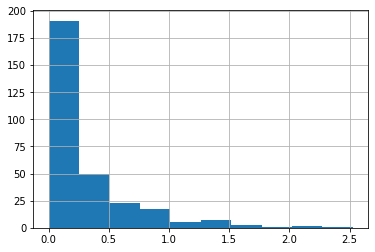

In [77]:
E['Values'].hist()